<center><h1>Diode leads resistance from a quench event</h1></center>

# 0. Initialise the working environment
## 0.1. Import useful packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

import pytimber
ldb = pytimber.LoggingDB()

from lhcsmapi.analysis.diode.DiodeLeadResistanceQuery import DiodeLeadResistanceQuery
from lhcsmapi.analysis.diode.DiodeLeadResistanceAnalysis import DiodeLeadResistanceAnalysis
from lhcsmapi.analysis.diode.DiodeLeadResistancePlot import DiodeLeadResistancePlot

from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from lhcsmapi.dbsignal.SignalAnalysis import SignalAnalysis
from lhcsmapi.dbsignal.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.Time import Time
from lhcsmapi.dbsignal.Signal import Signal

# 1. Get user input

In [3]:
use_case = input("Please, select use case: 1 (MQ.25R4 (RQD)) or 2 (MB.B9R1) =>")
use_case = use_case or '1'
print('Chosen case: ', use_case)
if use_case == '1':
    # Event 1 - MQ.25R4 (RQD)
    magnet = input("Magnet Name? [25R4]:")
    magnet = magnet or '25R4'
    circuit_name = input("Circuit Name? [RQD.A45]:")
    circuit_name = circuit_name or 'RQD.A45'
    circuit_type = circuit_name.split('.')[0]
    timestamp_iqps_qh = input("iQPS QH PM Time Stamp? [2018-12-09 09:55:47.668]:")
    timestamp_iqps_qh = timestamp_iqps_qh or '2018-12-09 09:55:47.668'
else:
    # Event 2 - MB.B9R1
    magnet = input("Magnet Name? [B9R1]:")
    magnet = magnet or 'B9R1'
    circuit_name = input("Circuit Name? [RB.A12]:")
    circuit_name = circuit_name or 'RB.A12'
    circuit_type = circuit_name.split('.')[0]
    timestamp_iqps_qh = input("iQPS QH PM Time Stamp? [2018-12-12 17:21:35.371]:")
    timestamp_iqps_qh = timestamp_iqps_qh or '2018-12-12 17:21:35.371'
#
print("-----")
print("Circuit=", circuit_type, "Sector=", circuit_name, "Magnet=", magnet)
print("Time stamp (iQPS)=", timestamp_iqps_qh)
#
# 25R4, RQD/RQF.A45, 2018-12-09 09:55:47.668, B26R4, dt = 0 - default for option 1
# 32L3, RQD/RQF.A23, 2018-07-19 15:19:17.699, B33L3 - very noisy event!
# 29L8, RQD/RQF.A78, 2016-06-06 08:34:33.667, B30L8
# 30R8, RQD/RQF.A81, 2018-12-03 15:21:05.372, B31R8, dt = 0
#
# B9R1, RB.A12, 2018-12-12 17:21:35.371, B11R1, dt = -0.51; - default for option 2
# A21R7, RB.A78, 2018-12-08 18:42:39.890, B21R7, dt = -76; - very surprising time stamp of nQPS!!!
# A26R1, RB.A12, 2018-12-09 06:20:54.729, B26R1, dt = xxx; - max at the end of EE-decay!?
# A31R1, RB.A12, 2018-12-12 17:21:34.793, B31R1

Please, select use case: 1 (MQ.25R4 (RQD)) or 2 (MB.B9R1) =>1
Chosen case:  1
Magnet Name? [25R4]:
Circuit Name? [RQD.A45]:
iQPS QH PM Time Stamp? [2018-12-09 09:55:47.668]:
-----
Circuit= RQD Sector= RQD.A45 Magnet= 25R4
Time stamp (iQPS)= 2018-12-09 09:55:47.668


# 2. Query signals from CALS and evaluate the diode leads resistance
## 2.1. Query and resample I_MEAS and U_DIODE_xxx from CALS

In [4]:
# get metadata - signal names
magnet_type, I_MEAS, U_DIODE = DiodeLeadResistanceQuery.get_magnet_type_i_meas_u_diode(magnet, circuit_name)

# query circuit current
i_meas_sync = DiodeLeadResistanceQuery.query_cals_signal(I_MEAS, timestamp_iqps_qh, magnet_type, ldb=ldb)
u_diode_sync = DiodeLeadResistanceQuery.query_cals_signal(U_DIODE, timestamp_iqps_qh, magnet_type, ldb=ldb)

# query diode voltage
u_diode = DiodeLeadResistanceAnalysis.calculate_resistance_cals(magnet, circuit_name, i_meas_sync, u_diode_sync)

## 2.2. Plot

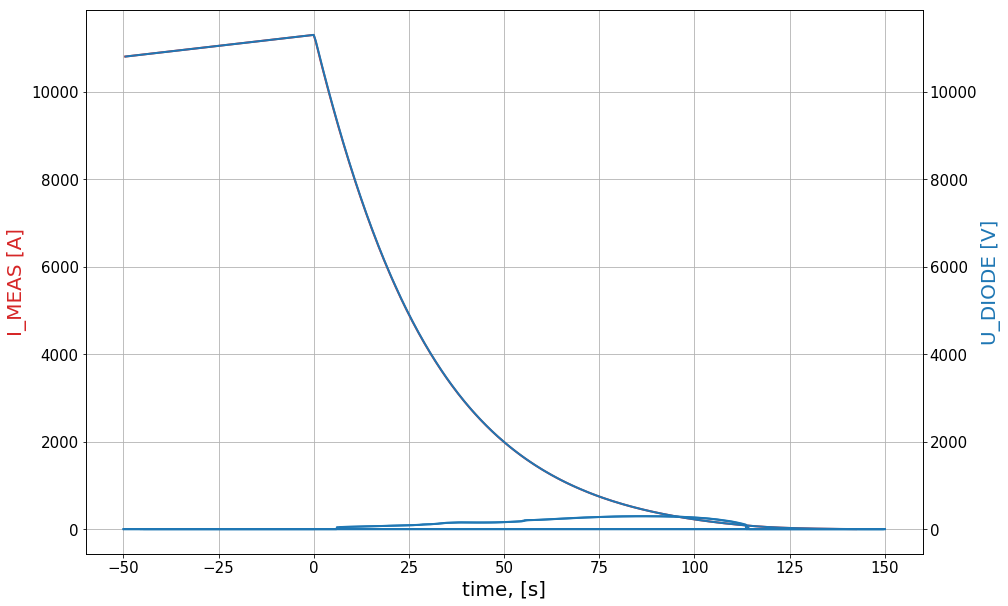

In [5]:
ax1 = i_meas_sync.plot(figsize=(15,10), legend=None, lw=2, color='C3')
ax1.set_xlabel("time, [s]", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylabel("I_MEAS [A]", color='C3', fontsize=20)
ax1.grid()

ax2 = ax1.twinx()
u_diode_sync.plot(ax=ax2, legend=None, lw=2, color='C0')
ax2.set_ylabel("U_DIODE [V]", color='C0', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## 2.3. Resampling I_MEAS

In [6]:
t_end = 350 if magnet_type == "MB" else 150
i_meas_sync_resampled = SignalAnalysis.resample(i_meas_sync, ts=0.1, t0=-50, t_end=t_end)

## 2.4. Plot

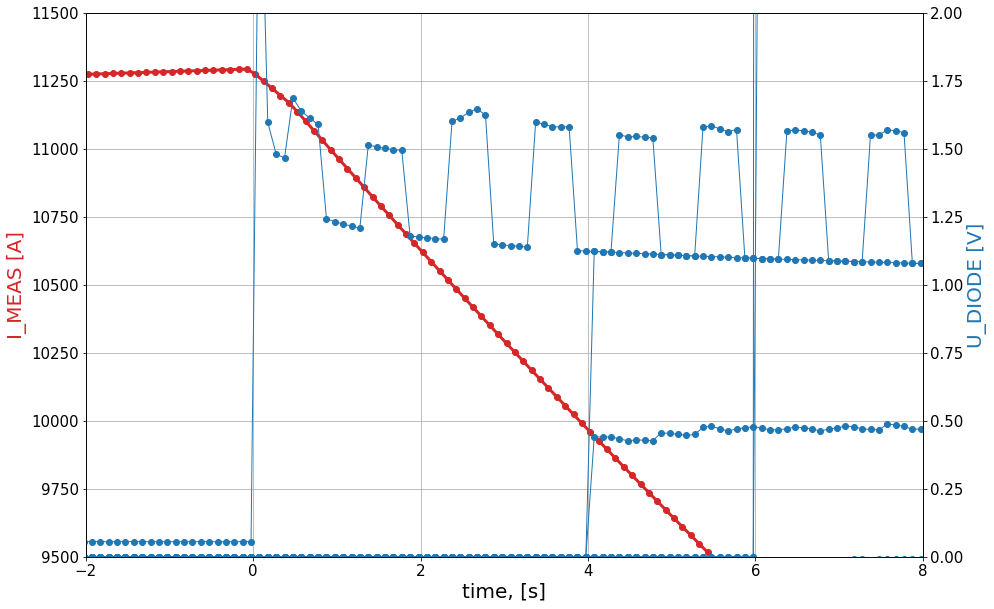

In [7]:
ax1 = i_meas_sync_resampled.plot(figsize=(15,10), legend=None, lw=3, marker='o', color='C3', ylim=(9500, 11500))
ax1.set_xlabel("time, [s]", fontsize=20)
ax1.tick_params(axis = 'both', which='major', labelsize=15)
ax1.set_ylabel("I_MEAS [A]", color='C3', fontsize=20)
ax1.grid()

ax2 = ax1.twinx()
u_diode_sync.plot(ax=ax2, legend=None, lw=1, marker='o', color='C0', xlim=(-2,8), ylim=(0,2))
ax2.set_ylabel("U_DIODE [V]", color='C0', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## 2.5. Evaluating resistive voltage drop

In [8]:
DiodeLeadResistanceAnalysis.calculate_minimum_diode_and_current_leads_voltage(u_diode_sync, U_DIODE)

## 2.6. Plot

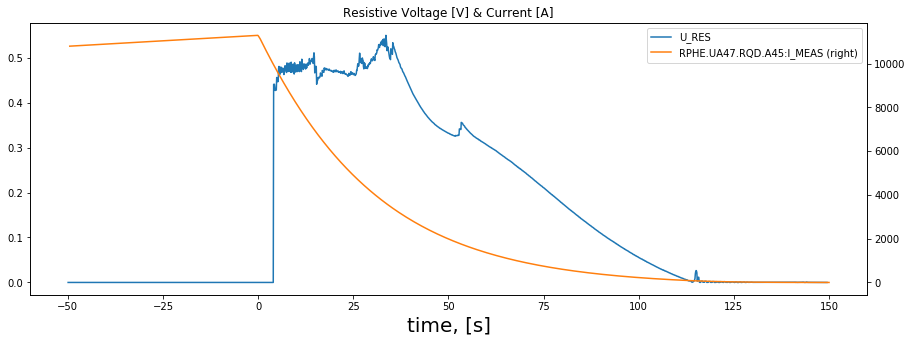

In [9]:
ax = u_diode_sync['U_RES'].plot(title='Resistive Voltage [V] & Current [A]', figsize=(15,5), legend='True')
i_meas_sync_resampled[I_MEAS].plot(ax=ax, secondary_y=True, legend='True')
ax.set_xlabel("time, [s]", fontsize=20)
plt.show()

## 2.7. Resistance calculation

In [10]:
# join current and diode voltage into a single dataframe
u_diode_sync[I_MEAS] = i_meas_sync_resampled[I_MEAS].values

# recover resistive and diode minimum voltage
DiodeLeadResistanceAnalysis.calculate_minimum_diode_and_current_leads_voltage(u_diode_sync, U_DIODE)

# calculate resistance
u_diode_sync['RES'] = u_diode_sync.apply(lambda row: 1e+6 * row['U_RES'] / row[I_MEAS], axis=1, raw=False)

# set to 0 resistance values for too low current and with too high diode voltage derivative
DiodeLeadResistanceAnalysis.set_to_zero_resistance_outside_of_range(u_diode_sync, I_MEAS)

# filter resistance
DiodeLeadResistanceAnalysis.filter_resistance(u_diode_sync)

# extract maximum resistance, time and current
res_max_cals, t_res_max_cals, i_res_max_cals = DiodeLeadResistanceAnalysis.extract_res_max_time_current_cals(u_diode_sync, I_MEAS)

## 2.8. Plot

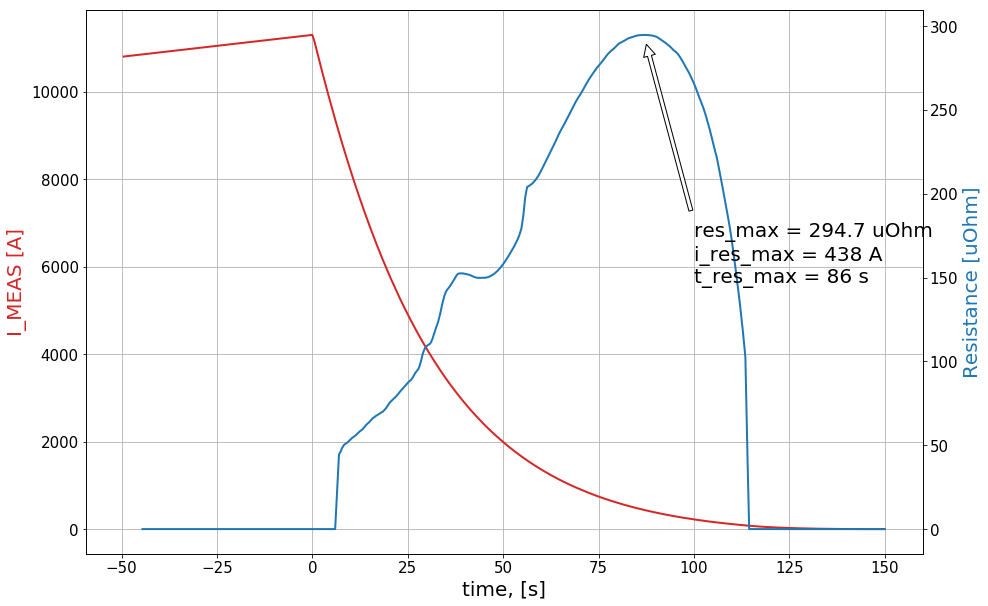

In [11]:
x_text = 200 if magnet_type == "MB" else 100
#
plotText = ('res_max = {:.1f} uOhm\ni_res_max = {} A\nt_res_max = {} s'.format(res_max_cals, int(i_res_max_cals), int(t_res_max_cals)))
#
ax1 = u_diode_sync[I_MEAS].plot(figsize=(15,10), legend=None, lw=2, color='C3')
ax1.set_xlabel("time, [s]", fontsize=20)
ax1.tick_params(axis = 'both', which='major', labelsize=15)
ax1.set_ylabel("I_MEAS [A]", color='C3', fontsize=20)
ax1.grid()

ax2 = ax1.twinx()
u_diode_sync['RES_filtered'].plot(ax=ax2, legend=None, lw=2, color='C0')
ax2.set_ylabel("Resistance [uOhm]", color='C0', fontsize=20)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.annotate(plotText, xytext=(x_text, res_max_cals/2), xy = (t_res_max_cals, res_max_cals), arrowprops=dict(facecolor='white', shrink=0.05),  fontsize=20)
plt.show()

# 3. Query signals from PMs (DS-buffers) and evaluate the diode leads resistance
## 3.1. Find nQPS and FGC PMs

In [15]:
timestamp_nqps = DiodeLeadResistanceQuery.find_diode_pm_entries(circuit_type[0:2], circuit_name, magnet, timestamp_iqps_qh)
print("Related nQPS PMs around {}: {}".format(timestamp_iqps_qh, len(timestamp_nqps)))
print(timestamp_nqps)

KeyError: "Signal type DIODE_RQ not present in ['CIP', 'CRYO', 'PIC', 'PC', 'QDS', 'QH', 'BUSBAR_RQD', 'DIODE_RQD', 'VF_RQD', 'LEADS', 'EE']."

In [ ]:
timestamp_fgc = DiodeLeadResistanceQuery.find_pc_pm_entries(circuit_type, circuit_name, timestamp_iqps_qh)
print("Related FGC PMs around {}: {}".format(timestamp_iqps_qh, len(timestamp_fgc)))
print(timestamp_fgc)

## 3.2. Query U_DIODE from QPS PM data (boards A and B) and I_A from FGC PM data

In [ ]:
time_corr = input("nQPS time correction? [0.0]:")
try:
    time_corr = float(time_corr) 
except:
    time_corr = float(0.0)

In [ ]:
# U_DIODE
timestamp_unix = Time.to_unix_timestamp(timestamp_iqps_qh)
system_diode = 'DIODE_RB' if magnet_type == "MB" else 'DIODE_RQD'
metadata_diode = SignalMetadata.get_circuit_signal_database_metadata(circuit_type, circuit_name, system_diode, 'PM')
class_name_qps, system_qps = metadata_diode['className'], metadata_diode['system']
source_qps = MappingMetadata.get_crate_name_from_magnet_name(circuit_type, magnet)
# A
u_diode_a = Signal().read('pm', system='QPS', className=class_name_qps, source=source_qps, signalName=U_DIODE, eventTime=timestamp_nqps[0])
u_diode_a = DiodeLeadResistanceAnalysis.preprocess_pm_qps_signal(time_corr, timestamp_unix, u_diode_a, U_DIODE)
# B
u_diode_b = Signal().read('pm', system='QPS', className=class_name_qps, source=source_qps, signalName=U_DIODE, eventTime=timestamp_nqps[1])
u_diode_b = DiodeLeadResistanceAnalysis.preprocess_pm_qps_signal(time_corr, timestamp_unix-1e+6, u_diode_b, U_DIODE)

In [ ]:
# U_REF
u_ref_name = SignalMetadata.get_signal_name(circuit_type, circuit_name, system_diode, 'PM', 'U_REF_N1').replace('%QPS_CRATE%', source_qps)

u_ref = Signal().read('pm', system='QPS', className=class_name_qps, source=source_qps, signalName=u_ref_name, eventTime=timestamp_nqps[0])
u_ref = DiodeLeadResistanceAnalysis.preprocess_pm_qps_signal(time_corr, timestamp_unix, u_ref, u_ref_name)

In [ ]:
# I_A
metadata_fgc = SignalMetadata.get_circuit_signal_database_metadata(circuit_type, circuit_name, 'PC', 'PM')
class_name_fgc, source_fgc = metadata_fgc['className'], metadata_fgc['source']
    
iab_i_a_name = SignalMetadata.get_signal_name(circuit_type, circuit_name, 'PC', 'PM', 'I_A')

iab_i_a = Signal().read('pm', system='FGC', className=class_name_fgc, source=source_fgc, signalName=iab_i_a_name, eventTime=timestamp_fgc[0])

index_start_diode = u_diode_a.index[0]
index_end_diode = u_diode_a.index[-1]
iab_i_a = DiodeLeadResistanceAnalysis.preprocess_pm_pc_signal(iab_i_a, iab_i_a_name, index_end_diode, index_start_diode, timestamp_unix)

## 3.3. Plot

In [ ]:
ax1 = iab_i_a.plot(figsize=(15,10), legend=None, lw=2, xlim=(-0.2, 1.0), ylim=(11360,11440), color='C3')
ax1.set_xlabel("time, [s]", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylabel("I_MEAS [A]", color='C3', fontsize=20)
ax1.grid()
ax2 = ax1.twinx()
u_diode_a.plot(ax=ax2, legend=None, lw=2, xlim=(-0.2, 1.0), color='C0')
u_diode_b.plot(ax=ax2, legend=None, lw=2, xlim=(-0.2, 1.0), color='C0')
u_ref.plot(ax=ax2, legend=None, lw=2, xlim=(-0.2, 1.0), color='C2')
ax2.set_ylabel("U_DIODE [V]", color='C0', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()
#
t_max = u_diode_a.idxmax(axis=0, skipna=True)[0]
#
ax1 = iab_i_a.plot(figsize=(15,10), legend=None, color='C3', lw=2, ylim=(11433, 11437))
ax1.set_xlabel("time, [s]", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylabel("I_MEAS [A]", color='C3', fontsize=20)
ax1.ticklabel_format(useOffset=False)
ax1.grid()

ax2 = ax1.twinx()
u_diode_a.plot(ax=ax2, legend=None, lw=2, xlim=(-0.05,+.150), ylim=(-2,+6), color='C0')
u_ref.plot(ax=ax2, legend=None, lw=2, xlim=(-0.05,+.150), ylim=(-2,+6), color='C2')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel("U_DIODE [V]", color='C0', fontsize=20)
plt.show()
#

## 3.4. Resistance Calculation

In [ ]:
u_diode_a_resampled = DiodeLeadResistanceAnalysis.resample_pm_signal(u_diode_a)
u_diode_b_resampled = DiodeLeadResistanceAnalysis.resample_pm_signal(u_diode_b)
iab_i_a_resampled = DiodeLeadResistanceAnalysis.resample_pm_signal(iab_i_a)

t_max = u_diode_a.idxmax(axis=0, skipna=True)[0]

# Calculate resistance
res = pd.DataFrame()
res['U_DIODE_A'] = u_diode_a_resampled[U_DIODE]
res['U_DIODE_B'] = u_diode_b_resampled.values
res['IAB.I_A'] = iab_i_a_resampled.values

DiodeLeadResistanceAnalysis.calculate_resistence(t_max, res)
res_max, t_res_max, i_res_max = DiodeLeadResistanceAnalysis.extract_res_max_time_current_pm(res)

## 3.5. Plot

In [ ]:
ax = res['U_RES'].plot(title='Resistive voltage', figsize=(15, 7.5), grid=True)
iab_i_a_resampled.plot(ax = ax, secondary_y=True, grid=True)

In [ ]:
x_text = 0.5 if magnet_type == "MB" else 1
#
plot_text = ('r_max = {:.1f} uOhm\ni_max = {} A\nt_max = {:.3f} s'.format(res_max, int(i_res_max), t_res_max))
#
ax = res['RES'].plot(title='Diode Lead Resistance [Ohm] & Current [A]', figsize=(15,7.6), legend = 'True', grid = 'True')
iab_i_a[iab_i_a_name].plot(ax=ax, secondary_y=True, legend = 'True', grid = 'True')
ax.annotate(
    plot_text, xytext=(x_text, res_max*1e-6/2), xy = (t_res_max, res_max*1e-6),
    arrowprops=dict(facecolor='white', shrink=0.05),  fontsize=15)